 Crear la matriz usuario-juego binaria

In [1]:
import pandas as pd

# Cargar el dataset
df = pd.read_csv("usuarios_steam_detallado.csv")

# Filtrar juegos con al menos algo de tiempo jugado
df = df[df["playtime_forever"] > 0]

# Contar cuántos usuarios han jugado cada juego
conteo_juegos = df.groupby("appid")["steam_id"].nunique()

# Establece un umbral mínimo de usuarios (ej. 50)
umbral_min_usuarios = 1000
juegos_validos = conteo_juegos[conteo_juegos >= umbral_min_usuarios].index

# Filtrar el DataFrame original
df_filtrado = df[df["appid"].isin(juegos_validos)]

print(f"✅ Juegos filtrados: {len(juegos_validos)}")
print(f"✅ Registros totales tras filtrado: {df_filtrado.shape[0]}")


✅ Juegos filtrados: 777
✅ Registros totales tras filtrado: 1825232


In [2]:
# Crear matriz binaria usuario-juego con los datos filtrados
df_filtrado["valor"] = 1
matriz_binaria = df_filtrado.pivot_table(
    index="steam_id", columns="appid", values="valor", fill_value=0
)

print(f"✅ Matriz binaria creada con forma: {matriz_binaria.shape}")


/tmp/ipykernel_33007/3272927076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["valor"] = 1


✅ Matriz binaria creada con forma: (25740, 777)


In [3]:
# Guardar la matriz binaria para usarla después
matriz_binaria.to_csv("matriz_binaria_filtrada.csv")
print("💾 Matriz binaria guardada como matriz_binaria_filtrada.csv")


💾 Matriz binaria guardada como matriz_binaria_filtrada.csv


In [4]:
from sklearn.decomposition import PCA
import joblib
import pandas as pd

# Reducimos a 50 dimensiones para clustering
pca = PCA(n_components=50, random_state=42)
matriz_reducida = pca.fit_transform(matriz_binaria)

print(f"✅ Matriz reducida con PCA: {matriz_reducida.shape}")

# Guardar el modelo PCA
joblib.dump(pca, "modelo_pca.joblib")

# Guardar las columnas de la matriz (los appid)
pd.to_pickle(matriz_binaria.columns.tolist(), "appids_entrenados.pkl")
print("💾 Guardado modelo PCA y columnas de juegos")


✅ Matriz reducida con PCA: (25740, 50)
💾 Guardado modelo PCA y columnas de juegos


In [5]:
from sklearn.cluster import KMeans
import joblib

# Puedes ajustar k si quieres más/menos clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(matriz_reducida)

# Crear DataFrame con los resultados
usuarios_clusters = pd.DataFrame({
    "steam_id": matriz_binaria.index,
    "cluster": clusters
})
print("✅ Clustering realizado")
print(usuarios_clusters['cluster'].value_counts())

# Guardar el modelo KMeans y los clusters
joblib.dump(kmeans, "modelo_kmeans.joblib")
usuarios_clusters.to_csv("usuarios_clusters.csv", index=False)
print("💾 Guardado modelo KMeans y usuarios_clusters.csv")


✅ Clustering realizado
cluster
1    14213
3     7220
2     3390
0      917
Name: count, dtype: int64
💾 Guardado modelo KMeans y usuarios_clusters.csv


In [6]:
usuarios_clusters.to_csv("usuarios_clusters.csv", index=False)


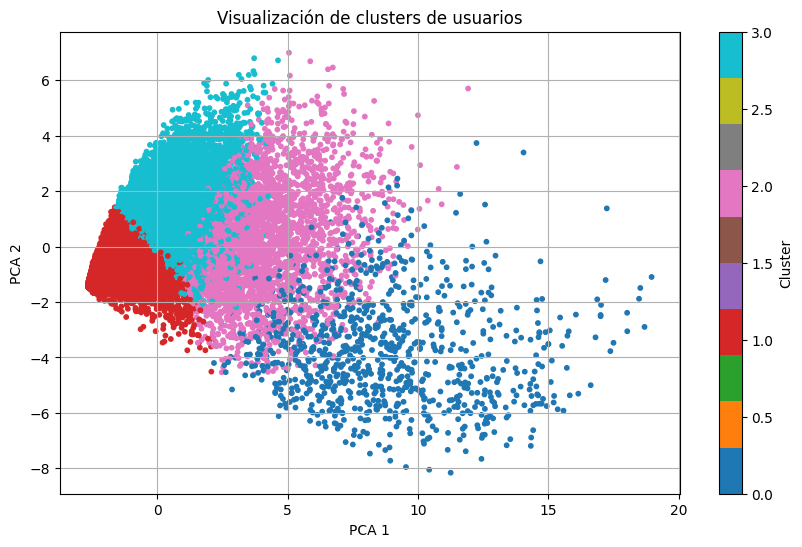

In [7]:
import matplotlib.pyplot as plt

# PCA a 2 dimensiones para visualización
pca_2d = PCA(n_components=2, random_state=42)
matriz_2d = pca_2d.fit_transform(matriz_reducida)

plt.figure(figsize=(10, 6))
plt.scatter(matriz_2d[:, 0], matriz_2d[:, 1], c=clusters, cmap='tab10', s=10)
plt.title("Visualización de clusters de usuarios")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.grid(True)
plt.show()


In [8]:
from pathlib import Path

# Asegúrate de tener esta carpeta
Path("transacciones_clusters").mkdir(exist_ok=True)

# Unimos clusters con interacciones
interacciones = df_filtrado[["steam_id", "appid"]].drop_duplicates()
interacciones_cluster = interacciones.merge(usuarios_clusters, on="steam_id")

for cluster_id in sorted(interacciones_cluster["cluster"].unique()):
    print(f"📦 Procesando cluster {cluster_id}...")

    # Crear transacciones por usuario
    transacciones = (
        interacciones_cluster[interacciones_cluster["cluster"] == cluster_id]
        .groupby("steam_id")["appid"]
        .apply(list)
    )

    if len(transacciones) < 10:
        print(f"⚠️ Muy pocos usuarios en el cluster {cluster_id}, saltando...")
        continue

    df_trans = pd.DataFrame({"steam_id": transacciones.index, "appids": transacciones})
    df_trans.to_pickle(f"transacciones_clusters/transacciones_cluster_{cluster_id}.pkl")
    print(f"✅ Guardado transacciones_cluster_{cluster_id}.pkl")


📦 Procesando cluster 0...
✅ Guardado transacciones_cluster_0.pkl
📦 Procesando cluster 1...
✅ Guardado transacciones_cluster_1.pkl
📦 Procesando cluster 2...
✅ Guardado transacciones_cluster_2.pkl
📦 Procesando cluster 3...
✅ Guardado transacciones_cluster_3.pkl


In [9]:
from collections import Counter

cluster_id =1 # Repite este bloque cambiando el ID para cada cluster

df = pd.read_pickle(f"transacciones_clusters/transacciones_cluster_{cluster_id}.pkl")

# Filtramos usuarios con al menos 3 juegos
df_filtrado = df[df["appids"].apply(lambda x: len(x) >= 3)]

# Contamos juegos más frecuentes
contador = Counter()
for juegos in df_filtrado["appids"]:
    contador.update(juegos)

# Solo mantenemos juegos jugados por al menos 10 usuarios
juegos_frecuentes = {j for j, c in contador.items() if c >= 10}

# Filtramos los juegos raros de las transacciones
df_filtrado["appids"] = df_filtrado["appids"].apply(
    lambda juegos: [j for j in juegos if j in juegos_frecuentes]
)
df_filtrado = df_filtrado[df_filtrado["appids"].apply(len) > 1]

df_filtrado.to_pickle(f"transacciones_clusters/transacciones_cluster_{cluster_id}_limpio.pkl")
print(f"✅ Transacciones limpias guardadas ({len(df_filtrado)})")


✅ Transacciones limpias guardadas (13493)


/tmp/ipykernel_33007/1251821392.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["appids"] = df_filtrado["appids"].apply(


In [10]:
from collections import Counter
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

cluster_id = 1  # Cambia por el que toque
df_trans = pd.read_pickle(f"transacciones_clusters/transacciones_cluster_{cluster_id}_limpio.pkl")

# Contar los juegos más frecuentes
contador = Counter(juego for sub in df_trans['appids'] for juego in sub)
top_juegos = {j for j, _ in contador.most_common(4000)}  # 🔁 AJUSTA a 100–200 si tienes RAM

# Filtrar transacciones solo con los juegos frecuentes
transacciones = [
    [j for j in juegos if j in top_juegos]
    for juegos in df_trans['appids']
]

# Eliminar las vacías o con un solo ítem
transacciones = [t for t in transacciones if len(t) > 1]
print(f"✅ Transacciones filtradas: {len(transacciones)} con {len(top_juegos)} juegos frecuentes")

# Codificación
te = TransactionEncoder()
te_ary = te.fit(transacciones).transform(transacciones)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
print("🎮 Juegos únicos tras codificación:", df_encoded.shape[1])

# Apriori
freq_items = apriori(df_encoded, min_support=0.02, use_colnames=True,  max_len=2)
print(f"📦 {len(freq_items)} itemsets frecuentes")

# Reglas
reglas = association_rules(freq_items, metric="lift", min_threshold=1.0)
print(f"📊 {len(reglas)} reglas generadas")

# Guardar
reglas["cluster"] = cluster_id
reglas.to_csv(f"reglas_cluster_{cluster_id}.csv", index=False)
print(f"✅ Reglas guardadas como reglas_cluster_{cluster_id}.csv")


✅ Transacciones filtradas: 13493 con 777 juegos frecuentes
🎮 Juegos únicos tras codificación: 777
📦 2660 itemsets frecuentes
📊 3868 reglas generadas
✅ Reglas guardadas como reglas_cluster_1.csv


In [11]:
from pathlib import Path
import pandas as pd
from joblib import load
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from ast import literal_eval
import requests

def recomendar_mba_para_usuario(steam_id, api_key):
    # Paso 1: Obtener juegos del usuario desde la API de Steam
    url = f"http://api.steampowered.com/IPlayerService/GetOwnedGames/v0001/?key={api_key}&steamid={steam_id}&format=json"
    response = requests.get(url)
    if response.status_code != 200:
        print("❌ Error al obtener los juegos del usuario desde la API.")
        return
    juegos_usuario = response.json().get("response", {}).get("games", [])
    appids_usuario = {j["appid"] for j in juegos_usuario if j.get("playtime_forever", 0) > 0}

    if not appids_usuario:
        print("⚠️ El usuario no tiene juegos jugados.")
        return

    # Paso 2: Cargar matriz binaria original y modelos
    matriz_binaria = pd.read_csv("matriz_binaria_filtrada.csv", index_col=0)
    pca = load("modelo_pca.joblib")
    kmeans = load("modelo_kmeans.joblib")
    columnas_appids = pd.read_pickle("appids_entrenados.pkl")

    # Paso 3: Crear vector binario para este usuario
    vector_usuario = pd.Series(0, index=columnas_appids)
    vector_usuario[list(appids_usuario & set(columnas_appids))] = 1

    # Paso 4: Reducir y asignar cluster
    vector_reducido = pca.transform([vector_usuario])
    cluster = int(kmeans.predict(vector_reducido)[0])
    print(f"🧠 Usuario asignado al cluster {cluster}")

    # Paso 5: Cargar reglas de asociación
    reglas_path = f"reglas_cluster_{cluster}.csv"
    if not Path(reglas_path).exists():
        print("⚠️ No hay reglas guardadas para este cluster.")
        return

    reglas = pd.read_csv(reglas_path)

    # Evaluar 'frozenset' correctamente si están en string
    if isinstance(reglas['antecedents'].iloc[0], str) and reglas['antecedents'].str.startswith('frozenset').any():
        reglas['antecedents'] = reglas['antecedents'].apply(eval)
        reglas['consequents'] = reglas['consequents'].apply(eval)
    elif isinstance(reglas['antecedents'].iloc[0], str):
        reglas['antecedents'] = reglas['antecedents'].apply(lambda x: frozenset(literal_eval(x)))
        reglas['consequents'] = reglas['consequents'].apply(lambda x: frozenset(literal_eval(x)))

    # Paso 6: Cargar nombres de juegos
    nombres_juegos = pd.read_csv("nombres_juegos.csv").set_index("appid")["name"].to_dict()

    # Paso 7: Filtrar reglas aplicables
    recomendaciones = []
    for _, fila in reglas.iterrows():
        if fila['antecedents'].issubset(appids_usuario) and not fila['consequents'].issubset(appids_usuario):
            appid = list(fila['consequents'])[0]
            recomendaciones.append((appid, fila['confidence'], fila['lift']))

    if not recomendaciones:
        print("🤷 No se encontraron recomendaciones para este usuario.")
        return

    # Paso 8: Mostrar top recomendaciones con nombres
    recomendaciones = sorted(recomendaciones, key=lambda x: (-x[1], -x[2]))[:10]
    print("\n🎯 Recomendaciones MBA para el usuario:")
    for appid, conf, lift in recomendaciones:
        nombre = nombres_juegos.get(appid, f"(Nombre no encontrado) AppID {appid}")
        print(f" - {nombre} (AppID {appid}) — Confianza: {conf:.2f}, Lift: {lift:.2f}")


In [12]:
API_KEY = "F8A4003EBB12D2357E82A7D7ED29F694"
USER_ID = "76561198235790210"
recomendar_mba_para_usuario(USER_ID, API_KEY)

❌ Error al obtener los juegos del usuario desde la API.
